# 12 - Hyperopt

- This is a Python library for optimizing discrete and continuous hyperparameters for XGBoost.
- This uses a probabilistic model to select the next set of hyperparameters to try.

- aside: first class functions in python:
    - python allows you to pass a function in as a parameter to another function or return a function as a result.

- this is a really useful chapter!

In [1]:
from setup import * #gets the real data

/media/ryan/5e52f95b-dbda-4605-bec6-10d513d58772/GitHubProjExt/effective-xgboost-notes/setup.py:32: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,42,44,54,56,64,81,83,85,87,105,107,109,121,123,125,148,150,157,172,174,192,194,210,218,219,221,223,246,247,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,302,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  kag = pd.read_csv(z.open(member_name))
/media/ryan/5e52f95b-dbda-4605-bec6-10d513d58772/GitHubProjExt/effective-xgboost-notes/setup.py:49: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education=df_.Q4.replace({'Master’s degree': 18,
/media/ryan/5e52f95b-dbda-4605-bec6-10d513d58772/GitHubProjEx

In [79]:
import numpy as np
import numpy.random as rn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree, dummy, preprocessing, ensemble
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
import dtreeviz
import yellowbrick.model_selection as ms
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, pyll
from typing import Any, Dict, Union, Sequence
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
#also, must install graphviz for plotting to work with xgb

In [5]:
def hyperparameter_tuning(space: Dict[str, Union[float, int]],\
    X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame,\
    y_test: pd.Series, early_stopping_rounds: int=50, metric:callable=accuracy_score) -> Dict[str, Any]:
    """
    Function for tuning hyperparameters. This is the wrong way to do it! Just a grid search/stepwise. 
    A better way is done in chapter 13. The better way takes a fraction of the time for the same parameters!
    """
    int_vals = ['max_depth','reg_alpha']
    space={k: (int(val) if k in int_vals else val) for k, val in space.items()}
    space['early_stopping_rounds'] = early_stopping_rounds
    model = xgb.XGBClassifier(**space)
    evaluation = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, eval_set=evaluation, verbose=False)
    pred = model.predict(X_test)
    score = metric(y_test, pred)
    return {'loss': -score, 'status': STATUS_OK, 'model':model}

In [6]:
options = {'max_depth': hp.quniform('max_depth', 1, 8, 1), #tree
    'min_child_weight': hp.loguniform('min_child_weight',-2,3),
    'subsample': hp.uniform('subsample', 0.5, 1), #stochastic
    'colsample_bytree': hp.uniform('colsample_bytree', .5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda',1,10),
    'gamma': hp.loguniform('gamma', -10, 10), #regularization
    'learning_rate': hp.loguniform('learning_rate',-7,0), #boosting
    'random_state':42
}   

trials = Trials()

In [9]:
best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, y_train, X_test, y_test), space=options, \
    algo=tpe.suggest, max_evals=2_000, trials=trials, timeout=60*5 ) #it will stop, but still give an answer at the time!

  0%|          | 0/2000 [00:00<?, ?trial/s, best loss=?]

 47%|████▋     | 942/2000 [05:00<05:37,  3.14trial/s, best loss: -0.7756906077348066]


## Pretty cool, there is a little tracker that comes with it

In [15]:
best['max_depth'] = int(best['max_depth'])

In [19]:
#if trust output despite time cutoff
long_params = best

In [ ]:
# long_params = {'max_depth': 6, #tree
#     'min_child_weight': 0.66784,
#     'subsample': 0.9998, #stochastic
#     'colsample_bytree': 0.6875,
#     'reg_alpha': 3.29799,
#     'reg_lambda': 7.8509,
#     'gamma': 0.0693632, #regularization
#     'learning_rate': 0.2143921, #boosting
#     'random_state':42
}   


In [18]:
# now can train a model with hyperparameters
xg_ex = xgb.XGBClassifier(**long_params, early_stopping_rounds=50, n_estimators=500)
xg_ex.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)], verbose=100)

[0]	validation_0-logloss:0.58802	validation_1-logloss:0.59120


[66]	validation_0-logloss:0.39076	validation_1-logloss:0.51176


/home/linuxbrew/.linuxbrew/Cellar/python@3.11/3.11.9/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [02:23:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "subsammple" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8415280350422588, device=None,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.015707122362867733,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6273184258434865,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3.7048292728340466, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
xg_ex.score

## 12.3 Defining Parameter Distributions

- `choice` function specifies a discrete set of values for a **categorical** hyperparameter
    - two arguments: 
        1. list of possible values
        2. (optional) distribution over these values (`pchoice`)

Note anitpattern!

```python
#NOOOOO!
# hp.choice and hp.pchoice are for categlorical only. They won't use neighborhood/proximity when updating search if 
# specify it like this!!
'num_leaves': hp.choice('num_leaves', list(range(20, 250, 10))),
'subsample': hp.choice('subsample', [.2, .4, .5, .6, .7, .8, .9])


#YESSSSSSSS! This will correctly use proximity
'num_leaves': hp.quniform('num_leaves', 20, 250, 10)
'subsample': hp.uniform('subsample', .2, .9)
```

In [21]:
#Example, generate a random value from a list of possible values `['a','b','c']`
pyll.stochastic.sample(hp.choice('value', ['a','b','c'])) # unfirom distribution

'b'

In [23]:
pyll.stochastic.sample(hp.pchoice('value', [(.05, 'a'),(.9, 'b'),(.05, 'c')]))

'b'

In [24]:
pyll.stochastic.sample(hp.uniform('value',0,1))

0.6281880845275393

In [26]:
def make_hist_plot(input_vals):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.hist(input_vals)

(array([ 994.,  969.,  983., 1009., 1008., 1006.,  974., 1047., 1020.,
         990.]),
 array([4.05745125e-05, 1.00020688e-01, 2.00000802e-01, 2.99980916e-01,
        3.99961030e-01, 4.99941144e-01, 5.99921258e-01, 6.99901372e-01,
        7.99881486e-01, 8.99861600e-01, 9.99841714e-01]),
 <BarContainer object of 10 artists>)

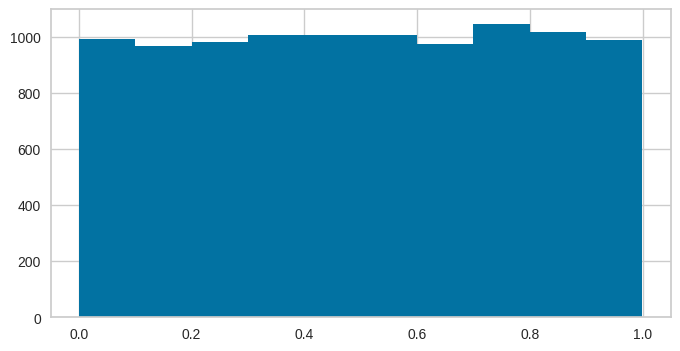

In [25]:
uniform_vals = [pyll.stochastic.sample(hp.uniform('value',0,1)) for j in range(10_000)]
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(uniform_vals)
# looks pretty uniform to me

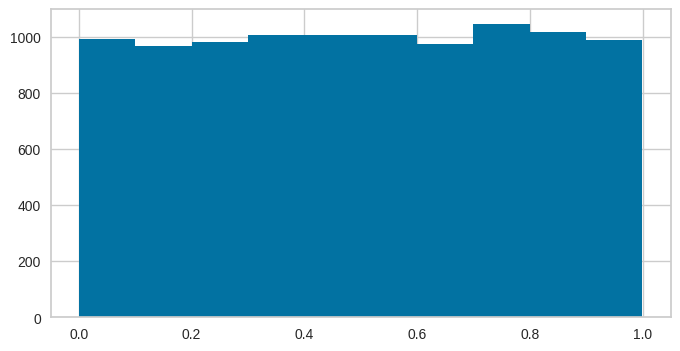

In [27]:
# can do simply! nice
make_hist_plot(uniform_vals)

In [28]:
loguniform_vals = [pyll.stochastic.sample(hp.loguniform('value', -5, 5)) for j in range(10_000)]

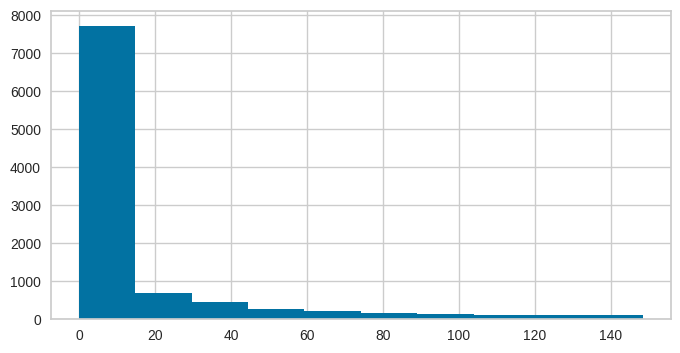

In [29]:
make_hist_plot(loguniform_vals) # favors the smaller

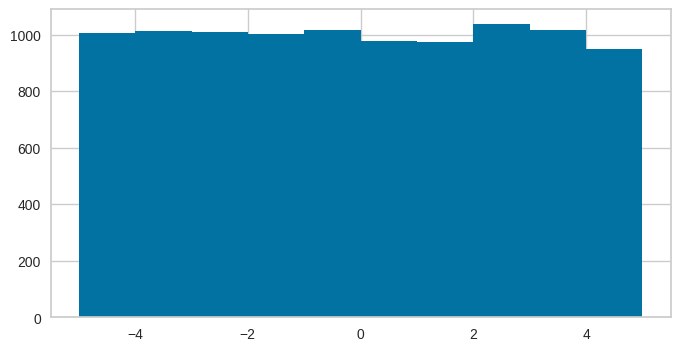

In [30]:
make_hist_plot(np.log(loguniform_vals)) # corrected, nice

In [32]:
quniform_vals = [pyll.stochastic.sample(hp.quniform('value',-5,5,q=2)) for j in range(10_000)]

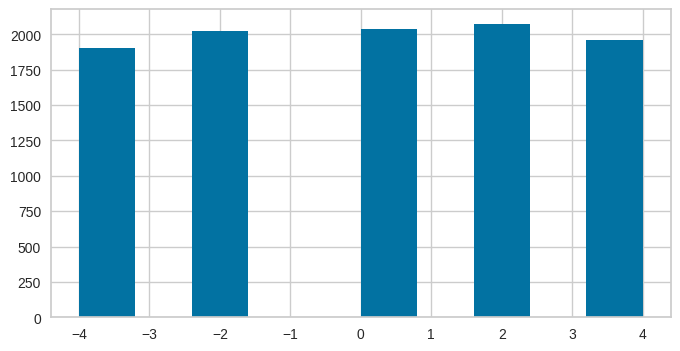

In [33]:
make_hist_plot(quniform_vals)

In [35]:
pd.Series(quniform_vals).value_counts()

 2.0    2074
 0.0    2037
-2.0    2024
 4.0    1959
-4.0    1906
Name: count, dtype: int64

- The below figure shows the exponential function and is highlighting there is a lot more x-space for small numbers than large numbers

<Axes: xlabel='x'>

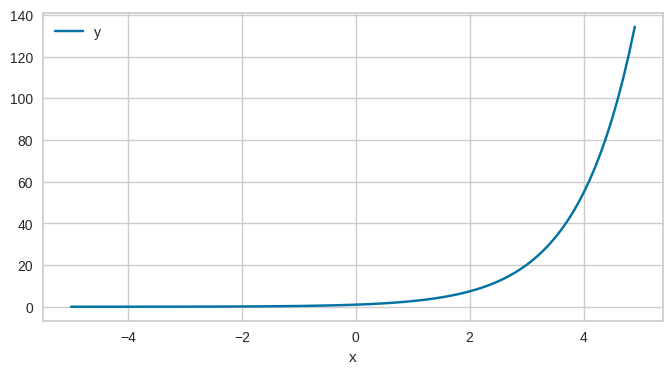

In [31]:
fig, ax = plt.subplots(figsize=(8,4))
(pd.Series(np.arange(-5,5, step=.1))
 .rename('x')
 .to_frame()
 .assign(y=lambda adf:np.exp(adf.x)) #works on a series and returns a dataframe
 .plot(x='x',y='y',ax=ax)
)

## Exploring the Trials

- the `trial` objet from the hyperopt search has the data about the hyperparameter optimization.

In [38]:
# converting trail object to pandas df
def trial2df(trial: Sequence[Dict[str, Any]]) -> pd.DataFrame:
    """
    Convert a trial object (sequence of trial dictionaries) to a Pandas DataFrame.

    Parameters:
    trial: List[Dict[str, Any]]
        A list of trial dictionaries.

    Returns
    pd.DataFrame - A DataFrame with columns for the loss, trial id, and values from each trial dictionary.
    """
    vals = [] #will be a list of dictionaries, then a pd.DataFrame
    for t in trial:
        result = t['result']
        misc = t['misc']
        val = {k:(v[0] if isinstance(v, list) else v) for k, v in misc['vals'].items()
               } #dictionary.
        val['loss'] = result['loss']
        val['tid'] = t['tid']
        vals.append(val)
    return pd.DataFrame(vals)

In [39]:
hyper2hr = trial2df(trials)
hyper2hr

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_alpha,reg_lambda,subsammple,loss,tid
0,0.956467,21.934858,0.083256,3.0,0.677834,1.912847,9.526343,0.827400,-0.729282,0
1,0.553200,0.000825,0.495477,1.0,0.154577,0.184028,4.646892,0.754405,-0.737017,1
2,0.861188,1019.062768,0.091982,7.0,6.223021,6.128938,6.293224,0.724574,-0.545856,2
3,0.955805,13396.823486,0.042038,8.0,0.201481,1.390248,3.955723,0.848307,-0.545856,3
4,0.578136,0.084168,0.156010,6.0,3.318269,2.314119,7.409979,0.876720,-0.769061,4
...,...,...,...,...,...,...,...,...,...,...
937,0.681450,0.014896,0.690639,4.0,13.262039,3.536161,8.504256,0.917240,-0.759116,937
938,0.845319,0.000073,0.080196,2.0,0.221944,0.440946,3.158741,0.847732,-0.750276,938
939,0.659872,0.004321,0.341471,3.0,0.375327,0.176962,3.941768,0.901661,-0.759116,939
940,0.968578,0.001448,0.097794,6.0,1.820810,0.963484,3.751395,0.883204,-0.761326,940


In [47]:
dir(trials)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_dynamic_trials',
 '_exp_key',
 '_ids',
 '_insert_trial_docs',
 '_trials',
 'aname',
 'argmin',
 'assert_valid_trial',
 'asynchronous',
 'attachments',
 'average_best_error',
 'best_trial',
 'count_by_state_synced',
 'count_by_state_unsynced',
 'delete_all',
 'fmin',
 'idxs',
 'idxs_vals',
 'insert_trial_doc',
 'insert_trial_docs',
 'losses',
 'miscs',
 'new_trial_docs',
 'new_trial_ids',
 'refresh',
 'results',
 'source_trial_docs',
 'specs',
 'statuses',
 'tids',
 'trial_attachments',
 'trials',
 'vals',
 'view']

In [48]:
for t in trials:
    print(t)

{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': -0.7292817679558011, 'status': 'ok', 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9564674527548034, device=None,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=21.934857986685557,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08325555166895561,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=0.6778341568893909, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workd

<Axes: >

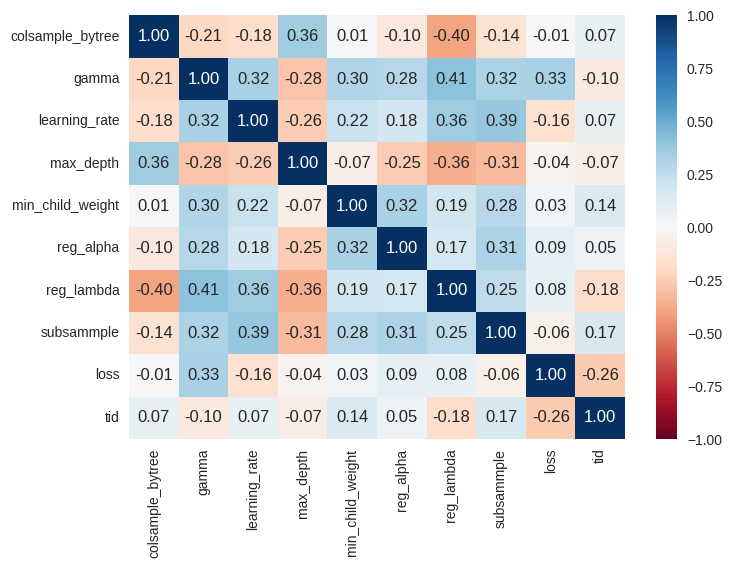

In [52]:
sns.heatmap(hyper2hr.corr(method='spearman'), cmap='RdBu', annot=True, fmt='.2f', vmin=-1,vmax=1)

In [53]:
#can do without seaborn too: just matplotlib
hyper2hr.corr(method='spearman').style.background_gradient(cmap='RdBu',vmin=-1,vmax=1)

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_alpha,reg_lambda,subsammple,loss,tid
colsample_bytree,1.000000,-0.209838,-0.181542,0.356523,0.010259,-0.102657,-0.402614,-0.144599,-0.005222,0.074950
gamma,-0.209838,1.000000,0.324148,-0.283075,0.297503,0.281303,0.407252,0.320163,0.327903,-0.100040
learning_rate,-0.181542,0.324148,1.000000,-0.256093,0.223845,0.183574,0.356661,0.390562,-0.159696,0.072102
max_depth,0.356523,-0.283075,-0.256093,1.000000,-0.068126,-0.252321,-0.363662,-0.314133,-0.037454,-0.067002
min_child_weight,0.010259,0.297503,0.223845,-0.068126,1.000000,0.323588,0.191971,0.277539,0.032025,0.144147
reg_alpha,-0.102657,0.281303,0.183574,-0.252321,0.323588,1.000000,0.173785,0.307104,0.091688,0.049675
reg_lambda,-0.402614,0.407252,0.356661,-0.363662,0.191971,0.173785,1.000000,0.251731,0.078541,-0.177399
subsammple,-0.144599,0.320163,0.390562,-0.314133,0.277539,0.307104,0.251731,1.000000,-0.055809,0.170974
loss,-0.005222,0.327903,-0.159696,-0.037454,0.032025,0.091688,0.078541,-0.055809,1.000000,-0.262299
tid,0.074950,-0.100040,0.072102,-0.067002,0.144147,0.049675,-0.177399,0.170974,-0.262299,1.000000


Note the negative correlation between tid and loss (-.26). This is because with more trials, diminishing marginal impact on loss function

<Axes: xlabel='max_depth', ylabel='loss'>

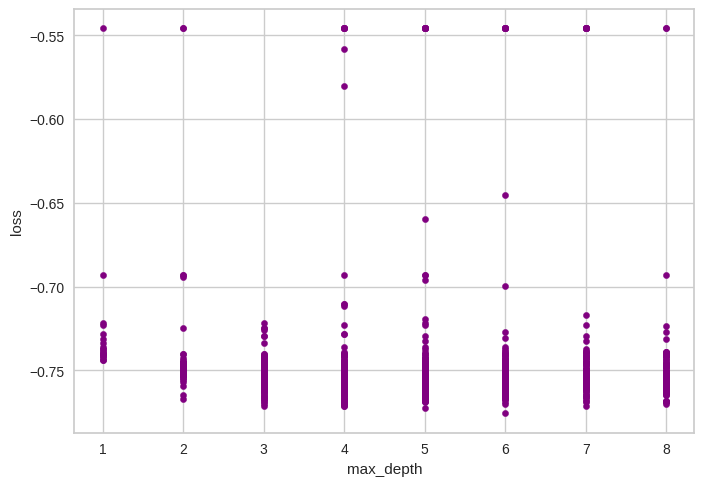

In [54]:
hyper2hr.plot.scatter(x='max_depth',y='loss', alpha=1, color='purple')

In [62]:
#there is a seaborn object
def jitter(df: pd.DataFrame, col: str, amount: float=1)-> pd.Series:
    vals = np.random.uniform(low=-amount/2,high=amount/2,size=df.shape[0])
    return df[col] + vals

<Axes: xlabel='max_depth', ylabel='loss'>

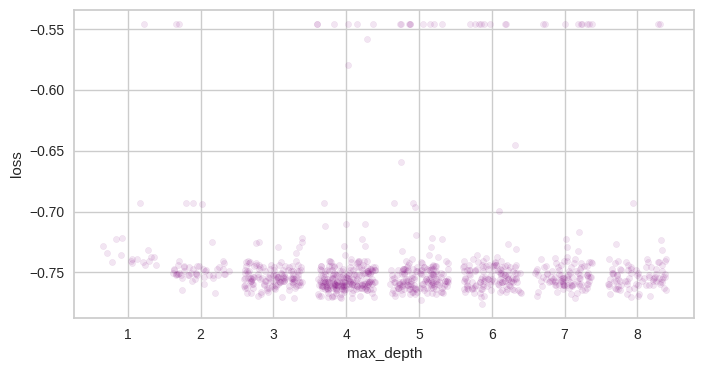

In [64]:
fig, ax = plt.subplots(figsize=(8,4))
(hyper2hr.assign(max_depth=lambda df:jitter(df, 'max_depth', amount=.8))
 .plot
 .scatter(x='max_depth',y='loss',alpha=.1, color='purple',ax=ax)
 )

<Axes: xlabel='max_depth', ylabel='loss'>

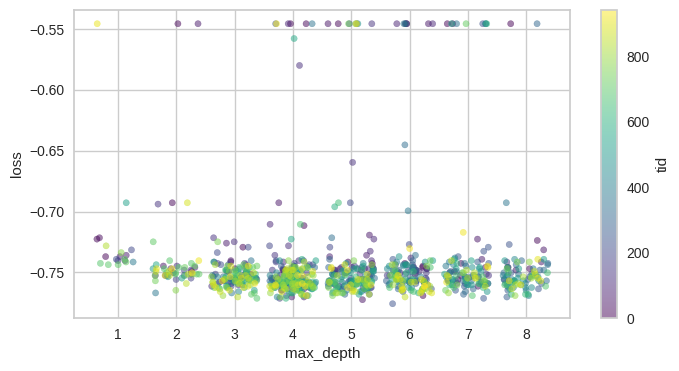

In [70]:
fig, ax = plt.subplots(figsize=(8,4))
(hyper2hr.assign(max_depth=lambda df:jitter(df, 'max_depth', amount=.8))
 .plot
 .scatter(x='max_depth',y='loss',alpha=.5,c='tid', cmap='viridis',ax=ax)
 )

/home/linuxbrew/.linuxbrew/Cellar/python@3.11/3.11.9/lib/python3.11/site-packages/seaborn/_core/plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


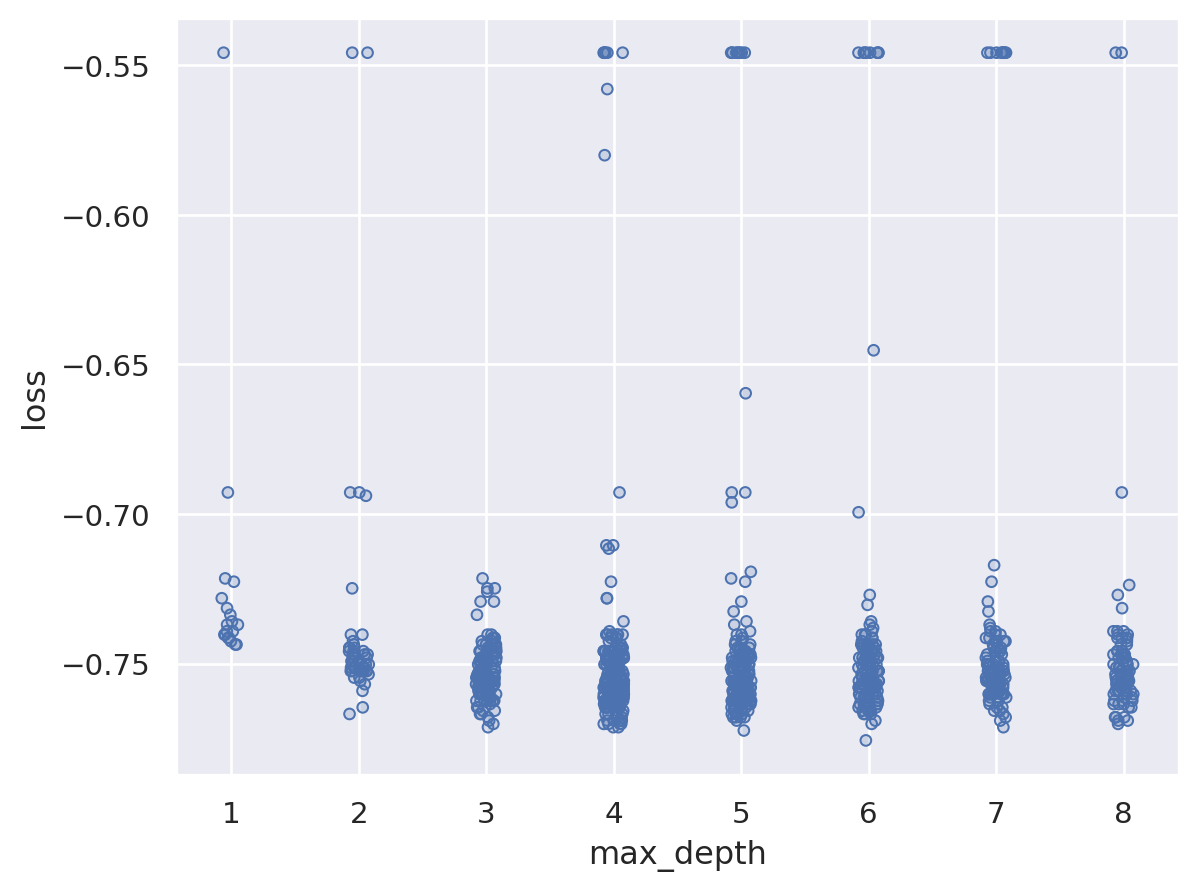

In [61]:
import seaborn.objects as so
so.Plot(data=hyper2hr,x='max_depth',y='loss').add(so.Dots(), so.Jitter()) #with seaborn objet jitter

<Axes: xlabel='max_depth', ylabel='loss'>

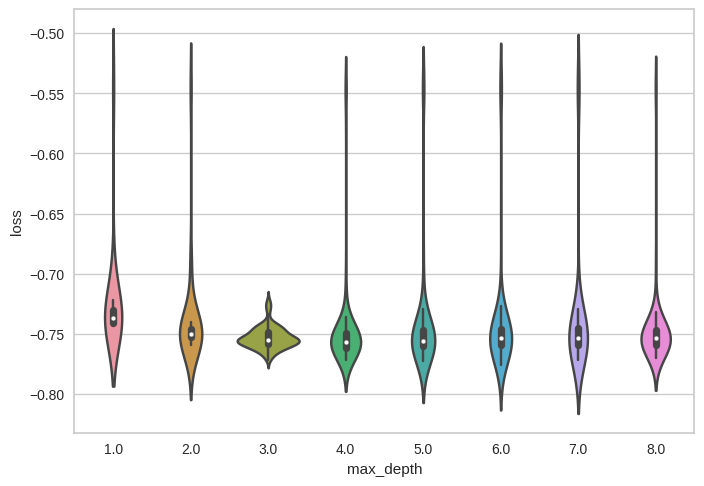

In [71]:
sns.violinplot(x='max_depth',y='loss',data=hyper2hr, kind='violin')

In [76]:
def plot_3d_mesh(df: pd.DataFrame, x_col: str, y_col: str, z_col: str) -> go.Figure:
    fig = go.Figure(data=[go.Mesh3d(x=df[x_col], y=df[y_col], z=df[z_col], intensity=df[z_col]/ df[z_col].min(),
        hovertemplate=f"{z_col}: %{{z}}<br>{x_col}: %{{x}}<br>{y_col}: %{{y}}<extra></extra>")],
    )
    fig.update_layout(
        title=dict(text=f'{y_col} vs {x_col}'),
        scene=dict(
            xaxis_title=x_col,
            yaxis_title=y_col,
            zaxis_title=z_col),
        width=700,
        margin=dict(r=20, b=10, l=10, t=50)
    )
    return fig

In [78]:
fig = plot_3d_mesh(hyper2hr.query('gamma<.2'),'reg_lambda','gamma','loss')
fig

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'loss: %{z}<br>reg_lambda: %{x}<br>gamma: %{y}<extra></extra>',
              'intensity': array([0.95014245, 0.99145299, 0.96723647, ..., 0.97863248, 0.98148148,
                                  0.98290598]),
              'type': 'mesh3d',
              'x': array([4.64689191, 7.40997942, 3.63195563, ..., 3.9417677 , 3.75139482,
                          1.67364379]),
              'y': array([0.00082465, 0.08416824, 0.00238835, ..., 0.00432071, 0.00144778,
                          0.00241467]),
              'z': array([-0.73701657, -0.76906077, -0.75027624, ..., -0.75911602, -0.76132597,
                          -0.76243094])}],
    'layout': {'margin': {'b': 10, 'l': 10, 'r': 20, 't': 50},
               'scene': {'xaxis': {'title': {'text': 'reg_lambda'}},
                         'yaxis': {'title': {'text': 'gamma'}},
                         'zaxis': {'title': {'text': 'loss'}}},
               'template': '...',
               'title': {'text': 'gamma vs reg_lambda'},
               'width': 700}
})

In [86]:
def plot_3d_scatter(df: pd.DataFrame, x_col: str, y_col: str, z_col: str, color_col: str, opacity: float=1) -> go.Figure:
    fig = px.scatter_3d(data_frame=df,x=x_col, y=y_col, z=z_col, \
        color=color_col,opacity=opacity)
    return fig

In [87]:
plot_3d_scatter(hyper2hr.query('gamma<.2'),'reg_lambda','gamma','tid',color_col='loss')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'reg_lambda=%{x}<br>gamma=%{y}<br>tid=%{z}<br>loss=%{marker.color}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': array([-0.73701657, -0.76906077, -0.75027624, ..., -0.75911602, -0.76132597,
                                         -0.76243094]),
                         'coloraxis': 'coloraxis',
                         'opacity': 1,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'scene': 'scene',
              'showlegend': False,
              'type': 'scatter3d',
              'x': array([4.64689191, 7.40997942, 3.63195563, ..., 3.9417677 , 3.75139482,
                          1.67364379]),
              'y': array([0.00082465, 0.08416824, 0.00238835, ..., 0.00432071, 0.00144778,
                          0.00241467]),
              'z': array([  1,   4,   8, ..., 939, 940, 941])}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'loss'}},
                             'colorscale': [[0.0, '#0d0887'], [0.1111111111111111,
                                            '#46039f'], [0.2222222222222222,
                                            '#7201a8'], [0.3333333333333333,
                                            '#9c179e'], [0.4444444444444444,
                                            '#bd3786'], [0.5555555555555556,
                                            '#d8576b'], [0.6666666666666666,
                                            '#ed7953'], [0.7777777777777778,
                                            '#fb9f3a'], [0.8888888888888888,
                                            '#fdca26'], [1.0, '#f0f921']]},
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'scene': {'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]},
                         'xaxis': {'title': {'text': 'reg_lambda'}},
                         'yaxis': {'title': {'text': 'gamma'}},
                         'zaxis': {'title': {'text': 'tid'}}},
               'template': '...'}
})